In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS

#### Inputs

Fix *cosmological* and *nuisance parameters*. Upload the corresponding linear power spectrum. You can also compute it using an Einstein-Boltzmann code like **CAMB**, **CLASS**, etc. 

Cosmological parameters:

Define a vector with the cosmological parameters, CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [2]:
#omega_i = Omega_i h² 
omega_b = 0.0224;        #baryons
omega_cdm = 0.12;       #CDM
omega_ncdm = 0.000;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.0;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

Linear power spectrum at redshift z_pk:

In [3]:
inputpkT = np.loadtxt('pk_linear.txt', unpack = True)

Nuisance parameters for the linear power spectrum:

Define a vector with the nuisances parameters, NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]

In [4]:
#bias parameters
b1 = 1;                 
b2 = 0;                 
bs2 = -4/7*(b1 - 1);        
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 1/0.002    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]

#### Computation of $M$ matrices 
**They do not depend on the cosmology**, so they are **computed only one time**. That is, the first time the code is called, it computes the $M$ matrices and stores them for the rest of the runs, which can be of the order of thousands in parameter estimations.

In [5]:
matrices = FOLPS.Matrices()

N = 128 sampling points
M matrices have been computed


In [6]:
Omfid = -1  # for AP set > 0

In [7]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]

In [8]:
# Compute 1loop integrals
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, Omfid = Omfid, AP=False)

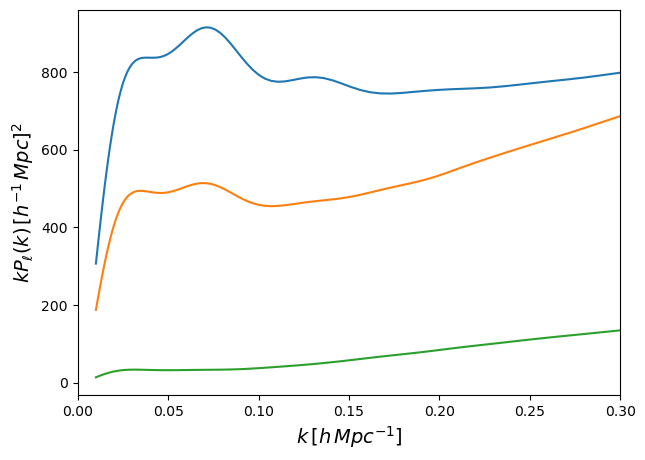

In [9]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(kh, kh * pkl0, label=r'$\ell = 0$')
axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')
axs.plot(kh, kh * pkl4, label=r'$\ell = 4$')

axs.set_xlim([0, 0.3])
plt.show()


# Run Bispectrum

In [10]:
# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1=0
c2=0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
bisp_cosmo_params = [(omega_cdm+omega_b+omega_ncdm)/h**2,h]

In [11]:
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 30) # array of k_ev in [h/Mpc]
k_ev_bk=np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))

In [12]:
Omfid = -1 # for AP

In [13]:
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000, B202 = FOLPS.Bisp_Sugiyama(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=[10,8,8])

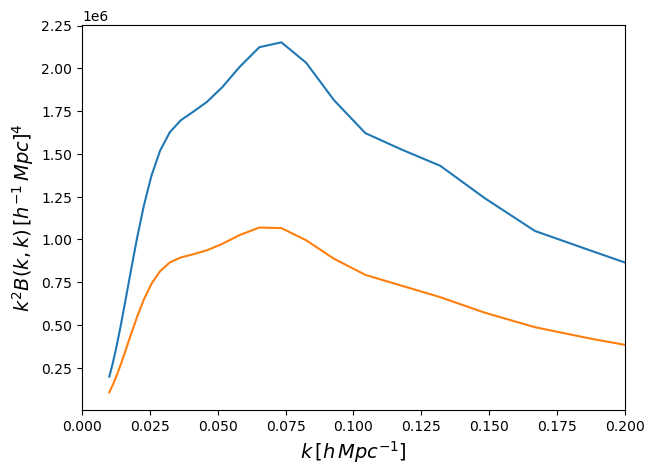

In [14]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize =  14)

axs.plot(k_ev, k_ev**2 * B000, label=r'B000')
axs.plot(k_ev, k_ev**2 * B202,label=r'B202')

axs.set_xlim([0, 0.20])
plt.show()